<a href="https://colab.research.google.com/github/Dinesh-Adhithya-H/Scalable-Machine-Learning-on-Big-Data-using-Apache-Spark/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark
import pyspark
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
sc=SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark=SparkSession.builder.getOrCreate()

     |████████████████████████████████| 212.4MB 66kB/s 
     |████████████████████████████████| 204kB 18.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=ead0a1a70d0f76bc86e752081f24cac8fe77196001c6d22ae5895fd6a9a8682d
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [4]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

--2021-06-05 11:14:19--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2021-06-05 11:14:19--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2021-06-05 11:14:19--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet

In [6]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

In [3]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [7]:
assembler=VectorAssembler(inputCols=result.columns,outputCol="features")

In [9]:
features=assembler.transform(result)

In [10]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [11]:
pca=PCA(k=3,inputCol="features",outputCol="pcafeatures")
model=pca.fit(features)

In [12]:
result_pca=model.transform(features).select("pcafeatures")
result_pca.show()

+--------------------+
|         pcafeatures|
+--------------------+
|[1459.97897058153...|
|[1459.99548182878...|
|[1460.08958435623...|
|[1469.69939294206...|
|[1469.71590418931...|
|[1469.71283173397...|
|[1478.35302645740...|
|[1478.35302645740...|
|[1478.36860361392...|
|[1478.36860361392...|
|[1483.54120276851...|
|[1483.51710902244...|
|[1483.42242685440...|
|[1483.42242685440...|
|[1488.10307354738...|
|[1488.10769268507...|
|[1488.01359015762...|
|[1488.02637455672...|
|[1465.16447384480...|
|[1465.16447384480...|
+--------------------+
only showing top 20 rows



In [13]:
result_pca.count()

2051

In [14]:
rdd = result_pca.rdd.sample(False,0.8)

In [17]:
x = rdd.map(lambda a : a.pcafeatures).map(lambda a : a[0]).collect()
y = rdd.map(lambda a : a.pcafeatures).map(lambda a : a[1]).collect()
z = rdd.map(lambda a : a.pcafeatures).map(lambda a : a[2]).collect()

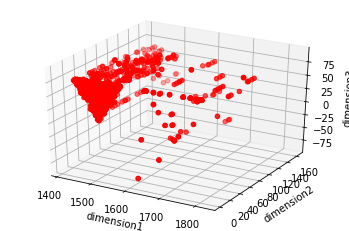

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c='r', marker='o')
ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')
plt.show()